In [1]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pandas as pd

figsize(12.5, 3.5)
count_data = np.loadtxt("시간별어노미표기법.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (hours)")
plt.ylabel("count of Anomal")
plt.title("Anomaly feature")
plt.xlim(0, n_count_data);

In [2]:
import pymc as pm

alpha = 1.0 / count_data.mean()  # Recall count_data is the
                               # variable that holds our txt counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [3]:
print("Random output:", tau.random(), tau.random(), tau.random())

Random output: 22 4 21


In [4]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2 
    return out

In [5]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [6]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 90.9 sec

In [7]:
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

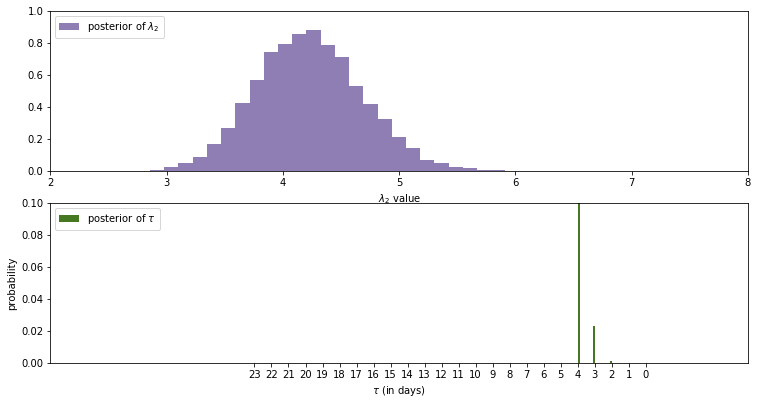

In [8]:
figsize(12.5, 10)

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([2, 8])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .100])
plt.xlim([35, len(count_data) - 30])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

In [9]:
data = lambda_2_samples
data_sorted = np.sort(data)

p = 1. * np.arange(len(data)) / (len(data) -1)

df = pd.DataFrame({'A' : data_sorted, 'B' : p})

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

x = find_nearest(p, 0.1)
c= df[df['B']==x]
m = c.A.values

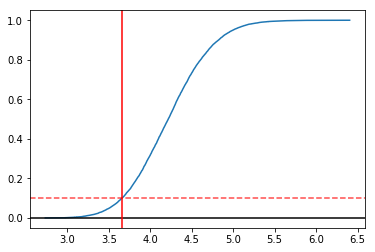

In [10]:
%matplotlib inline
from matplotlib import rc


plt.plot(data_sorted, p)

plt.axhline(0, color='black') 
plt.axhline(0.1, linestyle='--', color='red', alpha=.7)

plt.axvline(m, color='red')
